# Notebook to prepare field data for PyCleaner or Database upload

### Import standard and personal modules

In [8]:
# Import modules
#%matplotlib inline
#%matplotlib nbagg
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import os, sys, pdb, collections, datetime, time
from scipy.optimize import curve_fit, fmin
from scipy import interpolate
sys.path.append(os.path.abspath(os.path.join(os.curdir, '..', 'pycleaner')))
import functions.fielddata as fd
import fitfun as pff
import miscel
from matplotlib.ticker import FormatStrFormatter
from ipywidgets import widgets, Text, interactive, interact
from IPython.display import display, Image
import aux_functions as af
import mywidgets as mw

### Select what you want to do

Tick the boxes of the process you want to execute

In [9]:
renamefiles, joindata, ToPyCleaner, ToDatabase, plotlyAcc, ViewPlots = mw.ini_settings()

__1.- $EVOLUTION$ sensors__

Note: Before proceeding be sure to have a ${setup.dat}$ file in the source path (use following headers...):

                            Terminal	Sensor	Date(e.g.29062016)

In [10]:
SourceDir_evol = mw.createwidget('SourceDir', widgettype='text', bc='#AEE', defaultvalue=r'...Raw\evolution\12122012')
SourceDir_evol.on_submit(af.def_dir)

Directory (or file) < C:\Users\IRTG\Dropbox\LauswiesenDatabase\_Processed_Data\pumpingtests\evolution\2016\01072016 > is valid
Directory (or file) < C:\Users\IRTG\Dropbox\LauswiesenDatabase\_Processed_Data\pumpingtests\evolution\2016\work\01072016 > is valid
Directory (or file) < C:\Users\IRTG\Dropbox\LauswiesenDatabase\_Processed_Data\pumpingtests\evolution\2016\work > is valid
Directory (or file) < C:\Users\IRTG\Dropbox\LauswiesenDatabase\_Processed_Data\pumpingtests\evolution\2016\work > is valid


<IPython.core.display.Javascript object>


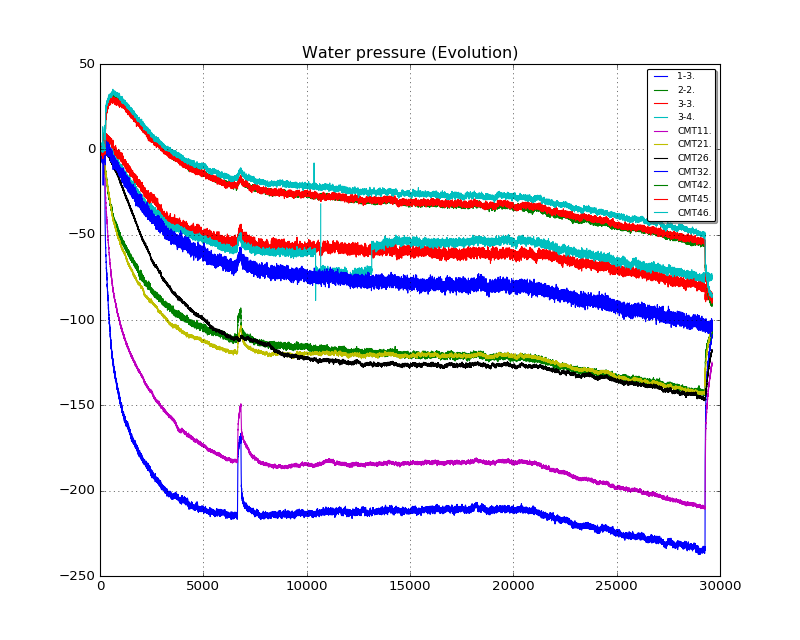

In [15]:
# For Simon: Transform this into a button widget:
wellsetup_fo = pd.read_table(os.path.join(SourceDir_evol.value, 'setup.dat'), header=0)
head_folders = sorted(os.listdir(SourceDir_evol.value))
fo_file_list = sorted(os.listdir(os.path.join(SourceDir_evol.value, head_folders[0])))
mydate = wellsetup_fo.keys()[2]
sorted_wellid = wellsetup_fo.sort_values('Terminal')['%s' %mydate]

if renamefiles.value is True:
    for cur_folder in head_folders:
        if (not '.rar' in cur_folder) and (not '.7z' in cur_folder) and ('.dat' not in cur_folder) and ('.txt' not in cur_folder):
            fd.rename_files(os.path.join(SourceDir_evol.value, cur_folder), sorted_wellid.values)

if joindata.value is True:
    for ii in fo_file_list:
        if ('Acquisition' in ii) or ('Log' in ii):
            pass
        else:
            mydict = {}
            basket = 0
            for cur_folder in head_folders:
                if ('.rar' in cur_folder) or ('_joined' in cur_folder) or ('.7z' in cur_folder) or (os.path.isfile(os.path.join(SourceDir_evol.value,cur_folder)) is True):
                    pass
                else:
#                     pdb.set_trace()
                    mydict["dataset%s" % basket] = fd.load_fiberoptic(os.path.join(SourceDir_evol.value, cur_folder), ii)
                    basket += 1
#             pdb.set_trace()
            fullset = fd.join_datasets(mydict)
            fd.savetxt_fiberoptic(os.path.join(SourceDir_evol.value, '%s_joined' %mydate), ii, fullset)

if ToPyCleaner.value is True:
    print('Evolution sensor data ready for Pycleaner')
if ToDatabase.value is True:
    print('Copy the data into the Structured directory')
    #img src="DB_structure.png"
    display(Image(filename = ".\DataSetsUpload_DB_structure.png"))
if ViewPlots.value is True:
    %matplotlib notebook
    fig2, ax2 = plt.subplots(1, figsize=(10, 8))
    ax2.set_title('Water pressure (Evolution)')
    for ii in os.listdir(os.path.join(SourceDir_evol.value, '%s_joined' %mydate)):
        fo_data = pd.read_csv(os.path.join(SourceDir_evol.value, '%s_joined' %mydate, ii), sep = '\t', header=0, usecols =(0,1, 2, 3))
        fo_data['date_time'] = pd.to_datetime(fo_data.date + ' ' + fo_data.time, infer_datetime_format=True)
        ax2.plot(fo_data.time_sec, fo_data.myhead, label=ii[:-3])
    ax2.legend(loc='best', fancybox=True, fontsize='x-small', shadow=True)
    ax2.grid(True)

__2.- $GRAPHTEC$ sensors__

Fill in the requiere entries, follow the conventions described in the default values

Notes:

   - First two entries of $Columns$ and $Headers$ should be as in the default values
   - VarType supports only 'water' or 'flow' at this moment

In [16]:
SourceDir_graphtec = mw.createwidget('SourceDir', widgettype='text', bc='#AEE', defaultvalue=r'...Raw\graphtec\12122012')
SourceFile_graphtec = mw.createwidget('SourceFile', widgettype='text', bc='#AEE', defaultvalue='myfile.csv')
cols2use = mw.createwidget('Columns', widgettype='text', bc='#AEE', defaultvalue='0,1,3,4,5')
myheaders = mw.createwidget('Headers', widgettype='text', bc='#AEE', defaultvalue='no,date_time,p_ch1,p_ch2,p_ch3')
well_list = mw.createwidget('WellList', widgettype='text', bc='#AEE', defaultvalue='B3TOP,B3MID,B3BOT')
vartype = mw.createwidget('VarType', widgettype='text', bc='#AEE', defaultvalue='Water,Water,Water')
SourceDir_graphtec.on_submit(af.def_dir)
# C:\PhD_Emilio\Emilio_PhD\Field_Data\_RawData\Pumping\Blacklogger\24062016

Data stored in individual txt files in <C:\Users\IRTG\Dropbox\LauswiesenDatabase\ipynb_1_RawData\pumpingtest\graphtec\24112015\24112015_single>


<IPython.core.display.Javascript object>


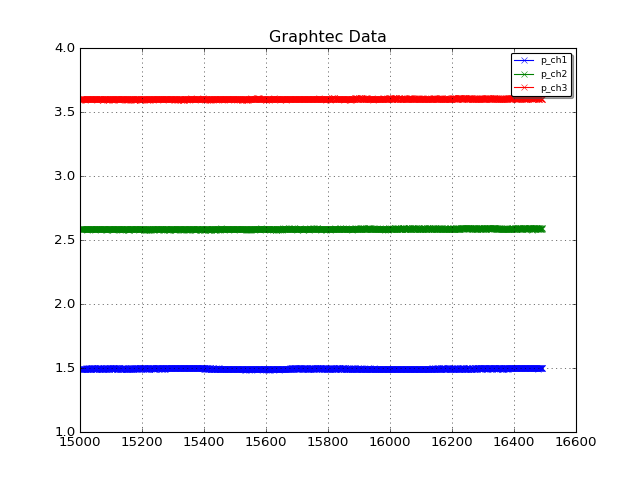

In [23]:
mydate = os.path.split(SourceDir_graphtec.value)[1]
mydata, mymeta = fd.load_graphtec(os.path.join(SourceDir_graphtec.value), SourceFile_graphtec.value, getMetadata=True, cols2use=np.array((cols2use.value).split(',')).astype(int), myheaders=(myheaders.value).split(',') )
fd.savetxt_graphtec(os.path.join(SourceDir_graphtec.value, '%s_single' %mydate), mydata, mymeta, (well_list.value).split(','),(vartype.value).split(',') )
bl_datetime = pd.Series([pd.to_datetime(cur_date, infer_datetime_format=True) for cur_date in mydata.date_time])
if ViewPlots.value is True:
    if plotlyAcc.value is False:
        %matplotlib notebook
        fig1, ax1 = plt.subplots()
        ax1.set_title('Graphtec Data')
        for ii in range(2,mydata.shape[1]):
            ax1.plot(mydata.no , mydata[mydata.columns[ii]], 'x-', label=mydata.columns[ii])
        ax1.legend(numpoints=1, fancybox=True, fontsize='x-small', shadow=True)
        #plt.xlim([215,225])
        ax1.grid(True)
    if plotlyAcc.value is True:
        %matplotlib nbagg
        import plotly.plotly as py
        import plotly.graph_objs as go
        trace0 = go.Scatter(x=mydata.no, y=mydata.p_ch1, name='Ch1-b3top')#, mode = 'lines+markers')
        trace1 = go.Scatter(x=mydata.no, y=mydata.p_ch2, name='Ch1-b3mid')#, mode = 'lines+markers')
        trace2 = go.Scatter(x=mydata.no, y=mydata.p_ch3, name='Ch1-b3bot')#, mode = 'lines+markers')
        data = go.Data([trace0, trace1, trace2])
        layout = go.Layout( title='Hydraulic pressure at injection well',
                        xaxis=dict(autorange=True,showgrid=True,zeroline=False,showline=False,autotick=True,showticklabels=True),
                        yaxis=dict(autorange=True,showgrid=True,zeroline=False,showline=False,autotick=True,
                                   ticks='',showticklabels=True )) 
        fig = go.Figure(data=data, layout=layout)

In [5]:
if (ViewPlots.value is True) and (plotlyAcc.value is True):
    py.iplot(fig, filename = 'basic-line')

C:\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:236: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.

C:\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:1443: UserWarning:

Estimated Draw Time Too Long



The draw time for this plot will be slow for all clients.


- This section is useful only if you want to extract the pumping initial and final times

In [ ]:
if (ViewPlots.value is True):
    def onmysub(sender):
        print('Time selected: %s' %pd.to_datetime(mydata['date_time'][np.where(mydata.no == int(sender.value))[0][0]]))
    to_index = mw.createwidget('StartID', widgettype='text', bc='#AEE', defaultvalue='1')
    tf_index = mw.createwidget('EndID', widgettype='text', bc='#AEE', defaultvalue='2')
    to_index.on_submit(onmysub)
    tf_index.on_submit(onmysub)
    t_ini = pd.to_datetime(mydata['date_time'][np.where(mydata.no == int(to_index.value))[0][0]])
    t_end = pd.to_datetime(mydata['date_time'][np.where(mydata.no == int(tf_index.value))[0][0]])

- This section will work properly only if Evolution and Graphtec where processed simultaneously:

In [ ]:
t_ini_trim_index = np.where(fo_data['date_time'] > t_ini)[0][0]
t_end_trim_index = np.where(fo_data['date_time'] > t_end)[0][0]
t_ini_trim_index, t_end_trim_index
print('Initial time in time format: %s' %fo_data['date_time'][t_ini_trim_index])
print('Initial time in seconds: %s' %fo_data['time_sec'][t_ini_trim_index])
print('Final time in time format: %s' %fo_data['date_time'][t_end_trim_index])
print('Final time in seconds: %s' %fo_data['time_sec'][t_end_trim_index])

__2.- $HERMES$ Fluorosensors__

- PlotType: 'all-in-one' or 'individual'

In [6]:
SourceDir_hermes = mw.createwidget('SourceDir', widgettype='text', bc='#AEE', defaultvalue=r'...Raw\hermes\12122012')
PlotType = mw.createwidget('PlotType', widgettype='text', bc='#AEE', defaultvalue=r'all-in-one or individual')
SourceDir_hermes.on_submit(af.def_dir)
PlotType.on_submit(af.def_dir)

Directory (or file) < C:\Users\IRTG\Dropbox\LauswiesenDatabase\_Processed_Data\tracertest\hermes\24062016 > is valid
Directory (or file) < all-in-one > is NOT valid!!!
Directory (or file) < individual > is NOT valid!!!


<IPython.core.display.Javascript object>


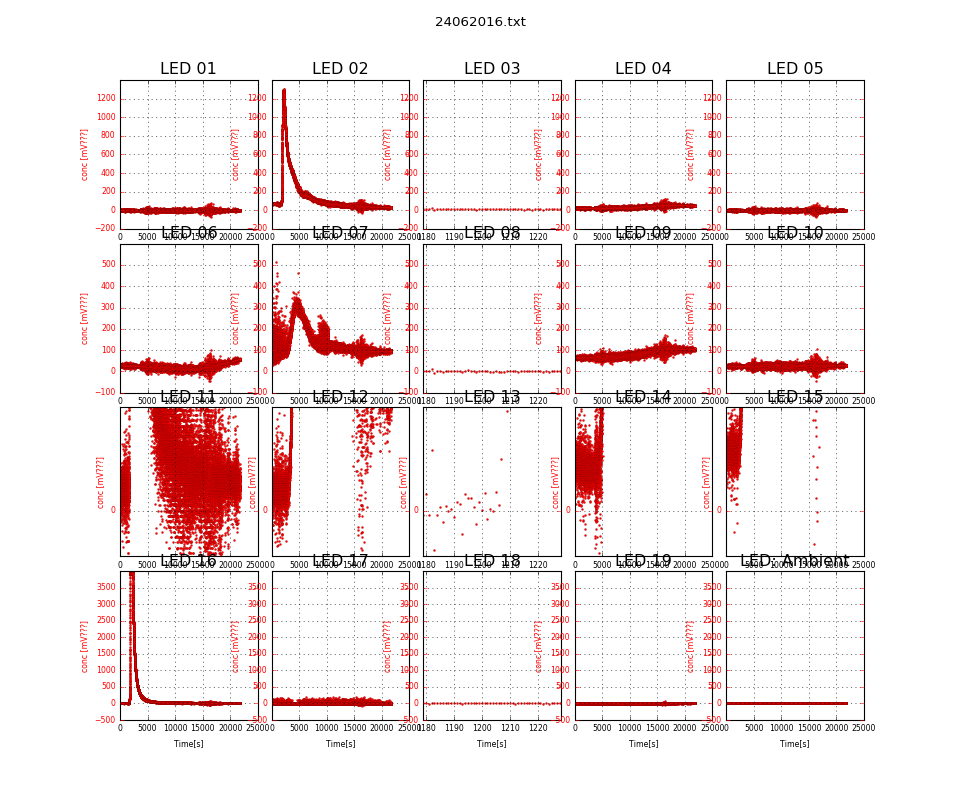

In [11]:
mydate = os.path.split(SourceDir_hermes.value)[-1]
if ViewPlots.value is True:
    %matplotlib notebook
    trash = fd.plot_19fluor(mydir=os.path.join(SourceDir_hermes.value, '%s.txt' %mydate), typeplot=PlotType.value, cols2plot='conc', contin_time=True)

In [9]:
tracer_dict, metadata = fd.load_tracer19(SourceDir_hermes.value, '%s.txt' %mydate, frequency=1, cont_time=True, getMetadata=True)
samplesetup_fo = pd.read_table(os.path.join(SourceDir_hermes.value, '%s_config.txt' %mydate), usecols=(0,2), skiprows=9, header=0 ) 
# samplesetup_fo.columns = ['wellid', 'led']
samplesetup_fo = samplesetup_fo.append(pd.DataFrame([[20,'Ambient']], columns=['led', 'well']), ignore_index=True)
fd.savetxt_tracer19(os.path.join(SourceDir_hermes.value, '%s_single' %mydate),
                    os.path.join(SourceDir_hermes.value, '%s_config.txt' %mydate),
                    tracer_dict, samplesetup_fo.well, meta_dict=metadata, minus_ambient=True)

Data stored in individual txt files in <C:\Users\IRTG\Dropbox\LauswiesenDatabase\_Processed_Data\tracertest\hermes\24062016\24062016_single>


In [8]:
injection_index, injection_time = mw.dirWidget(mymenus=['Tracer injectionIndex', 'Tracer injectionTime (HH:MM:SS):'], mytitle='Tracer injection times', defaults=['1', '1'])

In [12]:
print('Injection time according to the register in the field: %s' %tracer_dict['hour'][np.where(tracer_dict['hour'] > pd.to_datetime(injection_time.value).time())[0][0]])
print('Injection time according to the measured signal at the injection point: %s'  %tracer_dict['hour'][int(injection_index.value)])

Injection time according to the register in the field: 11:56:07
Injection time according to the measured signal at the injection point: 11:56:09
